运行的环境叫做pysyft，环境安装教程

```python
conda create -n pysyft python=3.7
conda activate pysyft
conda install pytorch==1.4.0 torchvision==0.5.0

# 方法二：
pip install -i https://pypi.tuna.tsinghua.edu.cn/simple --trusted-host pypi.tuna.tsinghua.edu.cn torch==1.4.0 torchvision==0.5.0
pip install syft==0.2.4 --no-dependencies
pip install lz4~=3.0.2 msgpack~=1.0.0 phe~=1.4.0 scipy~=1.4.1 syft-proto~=0.2.5.a1 tblib~=1.6.0 websocket-client~=0.57.0 pip install websockets~=8.1.0 zstd~=1.4.4.0 Flask~=1.1.1 tornado==4.5.3 flask-socketio~=4.2.1 lz4~=3.0.2 Pillow~=6.2.2 pip install requests~=2.22.0 numpy~=1.18.1
pip install protobuf==3.19.0

python -c "import syft,torch"
conda install ipykernel
```


In [1]:
#!/usr/bin/env py
import torchvision
from torch.utils.data import DataLoader, random_split
import torch
import syft as sy
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import xlwt

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

# 定义超参数

In [2]:
class Arguments():
    def __init__(self):
        self.batch_size = 32
        self.epochs = 50
        self.lr = 0.02
        self.num_class = 5
        self.save_name = 'yeo_cnn_lr0.01_epochs50'
        # self.data_train='../data/train_yeo_224/'
        # self.data_test='../data/test_yeo_224/'
        self.data_train = '/home/raoxy/data/train_yeo'
        self.data_test = '/home/raoxy/data/test_yeo'


args = Arguments()

# 定义参与者

In [3]:
hook = sy.TorchHook(torch)
bob = sy.VirtualWorker(hook, id="bob")
alice = sy.VirtualWorker(hook, id="alice")

In [4]:
federated_train_loader = sy.FederatedDataLoader(
    torchvision.datasets.ImageFolder(root=args.data_train,
                                     transform=torchvision.transforms.ToTensor()).federate((bob, alice)),
    batch_size=args.batch_size,
    shuffle=True)

In [5]:
federated_test_loader = DataLoader(
    torchvision.datasets.ImageFolder(root=args.data_test,
                                     transform=torchvision.transforms.ToTensor()),
    batch_size=args.batch_size,
    num_workers=0,
    shuffle=False)

# 定义训练模型

In [6]:
# class CNN(nn.Module):
#     def __init__(self, num_class):
#         super(CNN, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5)
#         self.conv2 = nn.Conv2d(64, 32, 5, padding=1)  # 输入通道数为64，输出通道数为64，卷积核大小为3x3，步长为1，填充为1
#         self.pool1 = nn.MaxPool2d(2)  # 最大池化层，池化核大小为2x2
#         self.gap = nn.AdaptiveAvgPool2d(5)  # 全局平均池化层
#         self.fc1 = nn.Linear(32, num_class)  # 全连接层 ，输入特征维度位256 ，输出特征维度位num_class
#         self.relu = nn.ReLU()  # 激活函数
#         self.dropout = nn.Dropout(p=0.5)  # 随机失活层
#         self.softmax = nn.LogSoftmax(dim=1)
#
#     def forward(self, x):
#         x = self.relu(self.conv1(x))
#         x = self.gap(x)
#         x = self.dropout(x)
#         x = self.relu(self.conv2(x))
#         x = self.pool1(x)
#         x = x.view(x.shape[0], -1)  # torch.Size([128, 32])
#         x = self.softmax(self.fc1(x))
#         return x
class CNN(nn.Module):
    def __init__(self, num_class):
        super(CNN, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(5),
            nn.Dropout(p=0.5)

        )
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 32, 5, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.block3 = nn.Sequential(
            nn.Linear(32, num_class),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = x.view(x.shape[0], -1)  # torch.Size([128, 32])
        x = self.block3(x)
        return x

# 定义训练函数和测试函数

In [7]:
def train(model, device, federated_train_loader, optimizer):
    model.train()
    correct = 0
    sample_num = 0
    total_loss = 0
    train_batch_num = len(federated_train_loader)

    for idx, (data, target) in enumerate(federated_train_loader):
        model.send(data.location)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target.long())
        loss.backward()
        optimizer.step()
        model.get()

        total_loss += loss.get().data
        pred = output.argmax(1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().get()
        sample_num += len(pred)

    return total_loss / train_batch_num, correct.cpu().item() / sample_num

In [8]:
def test(model, device, federated_test_loader):
    model.eval()
    correct = 0
    total_loss = 0
    sample_num = 0
    test_batch_num = len(federated_test_loader)

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(federated_test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)

            loss = F.cross_entropy(output, target.long())
            total_loss += loss.data

            pred = output.argmax(1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum()
            sample_num += len(pred)

    return total_loss.cpu() / test_batch_num, correct.cpu().item() / sample_num

# 模型训练

In [9]:
model = CNN(args.num_class).to(device)
optims = optim.SGD(model.parameters(), lr=args.lr)

train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
time_list = []
timestart = time.perf_counter()
for epoch in range(1, args.epochs + 1):
    epochstart = time.perf_counter()  # 每一个epoch的开始时间
    train_loss, train_acc = train(model, device, federated_train_loader, optims)
    elapsed = (time.perf_counter() - epochstart)  # 每一个epoch的结束时间 记录训练的耗时
    test_loss, test_acc = test(model, device, federated_test_loader)
    # 保存各个指际
    train_loss_list.append(train_loss.cpu())
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss.cpu())
    test_acc_list.append(test_acc)
    time_list.append(elapsed)
    print('epoch %d, train_loss %.6f,test_loss %.6f,train_acc %.6f,test_acc %.6f,time cost %.6f' % (
        epoch, train_loss, test_loss,
        train_acc, test_acc,elapsed))

epoch 1, train_loss 0.061645,test_loss 2.374795,train_acc 0.988234,test_acc 0.598577,time cost 192.800962
epoch 2, train_loss 0.007435,test_loss 1.396252,train_acc 0.998918,test_acc 0.798918,time cost 149.463460
epoch 3, train_loss 0.005142,test_loss 1.293294,train_acc 0.999146,test_acc 0.798918,time cost 147.669543
epoch 4, train_loss 0.004920,test_loss 1.227759,train_acc 0.999298,test_acc 0.798918,time cost 147.647121
epoch 5, train_loss 0.004403,test_loss 1.196973,train_acc 0.999298,test_acc 0.798918,time cost 147.807097
epoch 6, train_loss 0.004382,test_loss 1.151448,train_acc 0.999241,test_acc 0.798918,time cost 148.683764
epoch 7, train_loss 0.004721,test_loss 1.122587,train_acc 0.999336,test_acc 0.798918,time cost 161.677111
epoch 8, train_loss 0.004324,test_loss 1.047584,train_acc 0.999355,test_acc 0.798918,time cost 148.671674
epoch 9, train_loss 0.003500,test_loss 0.984865,train_acc 0.999260,test_acc 0.798918,time cost 147.567476
epoch 10, train_loss 0.003326,test_loss 0.9283

## 评价

- 模型在训练集上的表现非常好，准确率达到了100%，损失降到了0.0002以下。这说明您的模型能够很好地拟合训练数据，没有出现欠拟合的问题。
- 您的模型在测试集上的表现也很不错，准确率从0.5986提升到了0.9998，损失从2.4648降到了0.0028。这说明您的模型能够很好地泛化到新的数据，没有出现过拟合的问题。
- 您的模型的训练速度较快，每轮训练的平均时间消耗为139.7秒，总共花费了约1.5小时。这说明您的模型的复杂度适中，没有出现计算效率低下的问题。


# 训练数据保存

In [11]:
torch.save(model.state_dict(), "/home/raoxy/model/{}.pt".format(args.save_name))
print("保存文件：","/home/raoxy/model/{}.pt".format(args.save_name))

保存文件： /home/raoxy/model/yeo_cnn_lr0.01_epochs50.pt


In [12]:
torch.save(model, "/home/raoxy/model/{}.h5".format(args.save_name))
print("保存文件：","/home/raoxy/model/{}.h5".format(args.save_name))

保存文件： /home/raoxy/model/yeo_cnn_lr0.01_epochs50.h5


/home/raoxy/anaconda3/envs/pysyft/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## 创建workbook和sheet对象

In [13]:
def _change(a):
    b = []
    for i in a:
        b.append(float(i))
    return b

file_name = '/home/raoxy/file/{}.xlsx'.format(args.save_name)

## 写入Excel标题

In [14]:
workboot = xlwt.Workbook(encoding='utf-8')
worksheet = workboot.add_sheet('result')  # 设置工作表的名字

In [15]:
row0 = ["Train loss", "Train acc", "Test loss", 'Test acc', 'Time']
for i in range(len(row0)):
    worksheet.write(0, i, row0[i])

In [16]:
test_loss_list = _change(test_loss_list)
train_loss_list = _change(train_loss_list)
train_acc_list = _change(train_acc_list)
test_acc_list = _change(test_acc_list)
time_list = _change(time_list)

In [17]:
length = len(test_loss_list)

In [18]:
for i in range(1, length + 1):
    worksheet.write(i, 0, train_loss_list[i - 1])
    worksheet.write(i, 1, train_acc_list[i - 1])
    worksheet.write(i, 2, test_loss_list[i - 1])
    worksheet.write(i, 3, test_acc_list[i - 1])
    worksheet.write(i, 4, time_list[i - 1])
workboot.save(file_name)
print("保存文件：",file_name)

保存文件： /home/raoxy/file/yeo_cnn_lr0.01_epochs50.xlsx


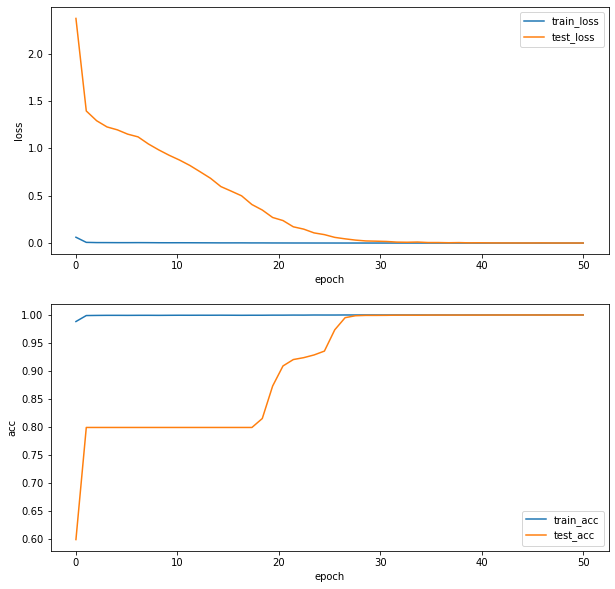

In [19]:
import matplotlib as mpl
from matplotlib import pyplot as plt

# mpl.use('nbAgg')
# mpl.style.use('seaborn-darkgrid')
import numpy as np
def plotP(test_loss, train_loss, train_acc_list, test_acc_list):
    plt.figure(figsize=(10, 10))
    x = np.linspace(0, len(train_loss), len(train_loss))
    y = np.linspace(0, len(train_acc_list), len(train_acc_list))
    plt.subplot(2, 1, 1)
    plt.plot(x, train_loss, label="train_loss")
    plt.plot(x, test_loss, label="test_loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.subplot(2, 1, 2)
    plt.plot(y, train_acc_list, label="train_acc")
    plt.plot(y, test_acc_list, label="test_acc")
    plt.xlabel("epoch")
    plt.ylabel("acc")
    plt.legend()
    plt.show()

plotP(test_loss_list, train_loss_list, train_acc_list, test_acc_list)

# 结果分析

In [20]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from utils import LoadData, write_result
import pandas as pd
import os
# from sklearn.metrics import *  # pip install scikit-learn
import matplotlib.pyplot as plt  # pip install matplotlib
import numpy as np  # pip install numpy
from numpy import interp
from sklearn.preprocessing import label_binarize
import torchvision
from datetime import datetime

class Arguments():
    def __init__(self):
        self.model_name = 'cnn' # cnn vgg16 resnet18
        self.data_name = 'yeo' # yeo quantile_ransformer
        self.confusion_name = '{}_{}_lr0.01_epoch50_test_confusion'.format(self.model_name, self.data_name)
        self.roc_name = '{}_{}_lr0.01_epochs50_test_roc'.format(self.model_name, self.data_name)

args = Arguments()

## 模型预测

### 生成预测的配置文件

In [21]:
verify_root='/home/raoxy/data/verify_yeo/'
true_label_txt='/home/raoxy/file/true_label_cnn_yeo.txt'

def Create_data_dir_with_true_label(_root, save_name):
    ''':cvar保存每一张图片的地址+对应的正确的标签'''
    _list = []
    for a, b, c in os.walk(_root):
        for i in range(len(c)):
            _list.append(os.path.join(a, c[i]))
    with open(save_name, 'w', encoding='UTF-8') as f:
        for _img in _list:
            f.write(_img + '\t' + str(_img.split('/')[-2]) + '\n')
    print("生成文件成功：",save_name)

Create_data_dir_with_true_label(verify_root, true_label_txt)

生成文件成功： /home/raoxy/file/true_label_cnn_yeo.txt


In [22]:
verify_root='/home/raoxy/data/verify_yeo/'
predicted_label_txt='/home/raoxy/file/predicted_label_cnn_yeo.txt'

def Create_data_dir_with_no_label(_root, save_name):
    _list = []
    for a, b, c in os.walk(_root):
        for i in range(len(c)):
            _list.append(os.path.join(a, c[i]))
    # print(_list)
    with open(save_name, 'w', encoding='UTF-8') as f:
        for _img in _list:
            f.write(_img + '\t' + "0" + '\n')
    print("生成文件成功：",save_name)

Create_data_dir_with_no_label(verify_root, predicted_label_txt)

生成文件成功： /home/raoxy/file/predicted_label_cnn_yeo.txt


### 加载模型

In [23]:
class CNN(nn.Module):
    def __init__(self, num_class):
        super(CNN, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(5),
            nn.Dropout(p=0.5)

        )
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 32, 5, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.block3 = nn.Sequential(
            nn.Linear(32, num_class),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = x.view(x.shape[0], -1)  # torch.Size([128, 32])
        x = self.block3(x)
        return x
    
device='cpu'
model_loc ="/home/raoxy/model/yeo_cnn_lr0.01_epochs50.pt"    
model_dict = torch.load(model_loc)
# model = model.to(device)
model = CNN(5)
model.load_state_dict(model_dict)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
print("加载权重文件：",model_loc)

Using cpu device
加载权重文件： /home/raoxy/model/yeo_cnn_lr0.01_epochs50.pt


### 预测

In [ ]:
# true_label_txt='/home/raoxy/file/true_label_cnn_yeo.txt'

def eval(dataloader, model):
    label_list = []
    likelihood_list = []
    pred_list = []
    model.eval()
    with torch.no_grad():
        # 加载数据加载器，得到里面的X（图片数据）和y(真实标签）
        for idx, (X, y) in enumerate(dataloader):
            # 将图片传入到模型当中就，得到预测的值pred
            pred = model(X)
            pred_softmax = torch.softmax(pred, 1).cpu().numpy()
            # 获取可能性最大的标签
            label = torch.softmax(pred, 1).cpu().numpy().argmax()
            label_list.append(label)
            # 获取可能性最大的值（即概率）
            likelihood = torch.softmax(pred, 1).cpu().numpy().max()
            likelihood_list.append(likelihood)
            pred_list.append(pred_softmax.tolist()[0])

        return label_list, likelihood_list, pred_list

valid_data = LoadData(true_label_txt  , train_flag=False)
_dataloader = DataLoader(dataset=valid_data, num_workers=4, pin_memory=True, batch_size=1)

label_list, likelihood_list, pred = eval(_dataloader, model)

### 将输出保存到exel中，方便后续分析

In [25]:
save_name = 'cnn_yeo_lr0.01_epochs50_verify'

label_names = ['R', 'RPM', 'gear', 'DoS', 'Fuzzy']
df = pd.DataFrame(data=pred, columns=label_names)
df.to_csv('/home/raoxy/file/{}.csv'.format(save_name), encoding='utf-8', index=False)
print('执行完毕，生成文件：/home/raoxy/file/{}.csv'.format(save_name))

执行完毕，生成文件：/home/raoxy/file/cnn_yeo_lr0.01_epochs50_verify.csv


## 绘图

In [ ]:
target_data = pd.read_csv(true_label_txt, sep="\t", names=["loc", "type"])
true_label = [i for i in target_data["type"]]

In [36]:
set(true_label)

{0, 1, 2, 3, 4}

In [27]:
save_name = 'cnn_yeo_lr0.01_epochs50_verify'

predict_loc ='/home/raoxy/file/{}.csv'.format(save_name)    # 3.ModelEvaluate.py生成的文件
predict_data = pd.read_csv(predict_loc)#,index_col=0)
predict_label = predict_data.to_numpy().argmax(axis=1)
predict_score = predict_data.to_numpy().max(axis=1)
# predict_score = predict_data.to_numpy().max(axis=1)
# # 精度，准确率， 预测正确的占所有样本种的比例
print(len(predict_label))

17565


In [28]:
from sklearn.metrics import accuracy_score  # pip install scikit-learn
accuracy = accuracy_score(true_label, predict_label)
print("精度: ",accuracy)

精度:  0.3994876174210077


## 查准率P（准确率），precision(查准率)=TP/(TP+FP)

In [29]:
from sklearn.metrics import precision_score
precision = precision_score(true_label, predict_label, labels=None, pos_label=1, average='macro') # 'micro', 'macro', 'weighted'
print("查准率P: ",precision)

查准率P:  0.16032716595725738


/home/raoxy/anaconda3/envs/pysyft/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 查全率R（召回率），原本为对的，预测正确的比例；recall(查全率)=TP/(TP+FN)

In [30]:
from sklearn.metrics import recall_score
recall = recall_score(true_label, predict_label, average='macro') # 'micro', 'macro', 'weighted'
print("召回率: ",recall)

召回率:  0.4


## F1-Score

In [31]:
from sklearn.metrics import f1_score

f1 = f1_score(true_label, predict_label, average='macro')     # 'micro', 'macro', 'weighted'
print("F1 Score: ",f1)

F1 Score:  0.2287255634164092


## 混淆矩阵

<Figure size 1080x1080 with 0 Axes>

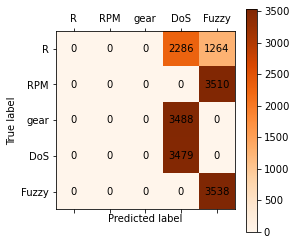

执行完毕，生成文件：/home/raoxy/img/cnn_yeo_Confusion_Matrix.png


<Figure size 432x288 with 0 Axes>

In [32]:
_fig_title='cnn_yeo'
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(15, 15))
label_names = ['R', 'RPM',  'gear', 'DoS', 'Fuzzy']
confusion = confusion_matrix(true_label, predict_label, labels=[i for i in range(len(label_names))])
plt.matshow(confusion, cmap=plt.cm.Oranges)   # Greens, Blues, Oranges, Reds
plt.colorbar()
for i in range(len(confusion)):
    for j in range(len(confusion)):
        plt.annotate(confusion[j,i], xy=(i, j), horizontalalignment='center', verticalalignment='center')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(range(len(label_names)), label_names)
plt.yticks(range(len(label_names)), label_names)
# plt.title("{} Confusion Matrix".format(_fig_title))
plt.show()
plt.savefig('/home/raoxy/img/{}_Confusion_Matrix.png'.format(_fig_title),bbox_inches="tight")
print('执行完毕，生成文件：/home/raoxy/img/{}_Confusion_Matrix.png'.format(_fig_title))

## ROC曲线

In [33]:
from sklearn.metrics import roc_curve,auc

n_classes = len(label_names)
# binarize_predict = label_binarize(predict_label, classes=[i for i in range(n_classes)])
binarize_predict = label_binarize(true_label, classes=[i for i in range(n_classes)])
# 读取预测结果
predict_score = predict_data.to_numpy()
# 计算每一类的ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binarize_predict[:,i], [socre_i[i] for socre_i in predict_score])
    roc_auc[i] = auc(fpr[i], tpr[i])
print("roc_auc = ",roc_auc)

roc_auc =  {0: 0.999788315336184, 1: 1.0, 2: 0.27292747034169207, 3: 1.0, 4: 0.9999602942125304}


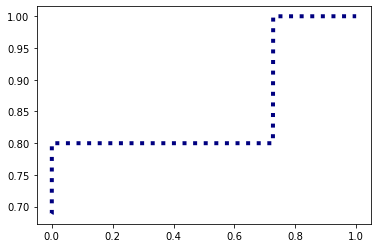

In [34]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
# Plot all ROC curves
lw = 2
plt.figure()
plt.plot(fpr["macro"], tpr["macro"],
         label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

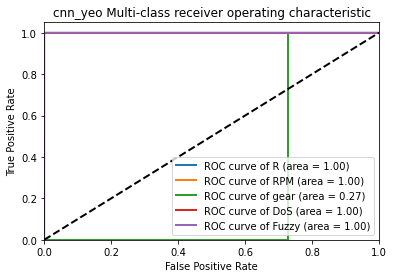

In [35]:
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=lw, label='ROC curve of {0} (area = {1:0.2f})'.format(label_names[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

_fig_title='cnn_yeo'
plt.title('{} Multi-class receiver operating characteristic'.format(_fig_title))
plt.legend(loc="lower right")
plt.show()
# plt.savefig('../img/{}_roc_fig.png'.format(args._fig_title),bbox_inches="tight")
# print('执行完毕生成文件：../img/{}_roc_fig.png'.format(_fig_title))